In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 14
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 32


In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False,kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False,kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    
    ap_residual = AveragePooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalAveragePooling2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 64)   256         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 64)     36864       spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 64)     256         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 64)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 64)     0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 64)           0           spatial_dropout2d_9[0][0]        
__________

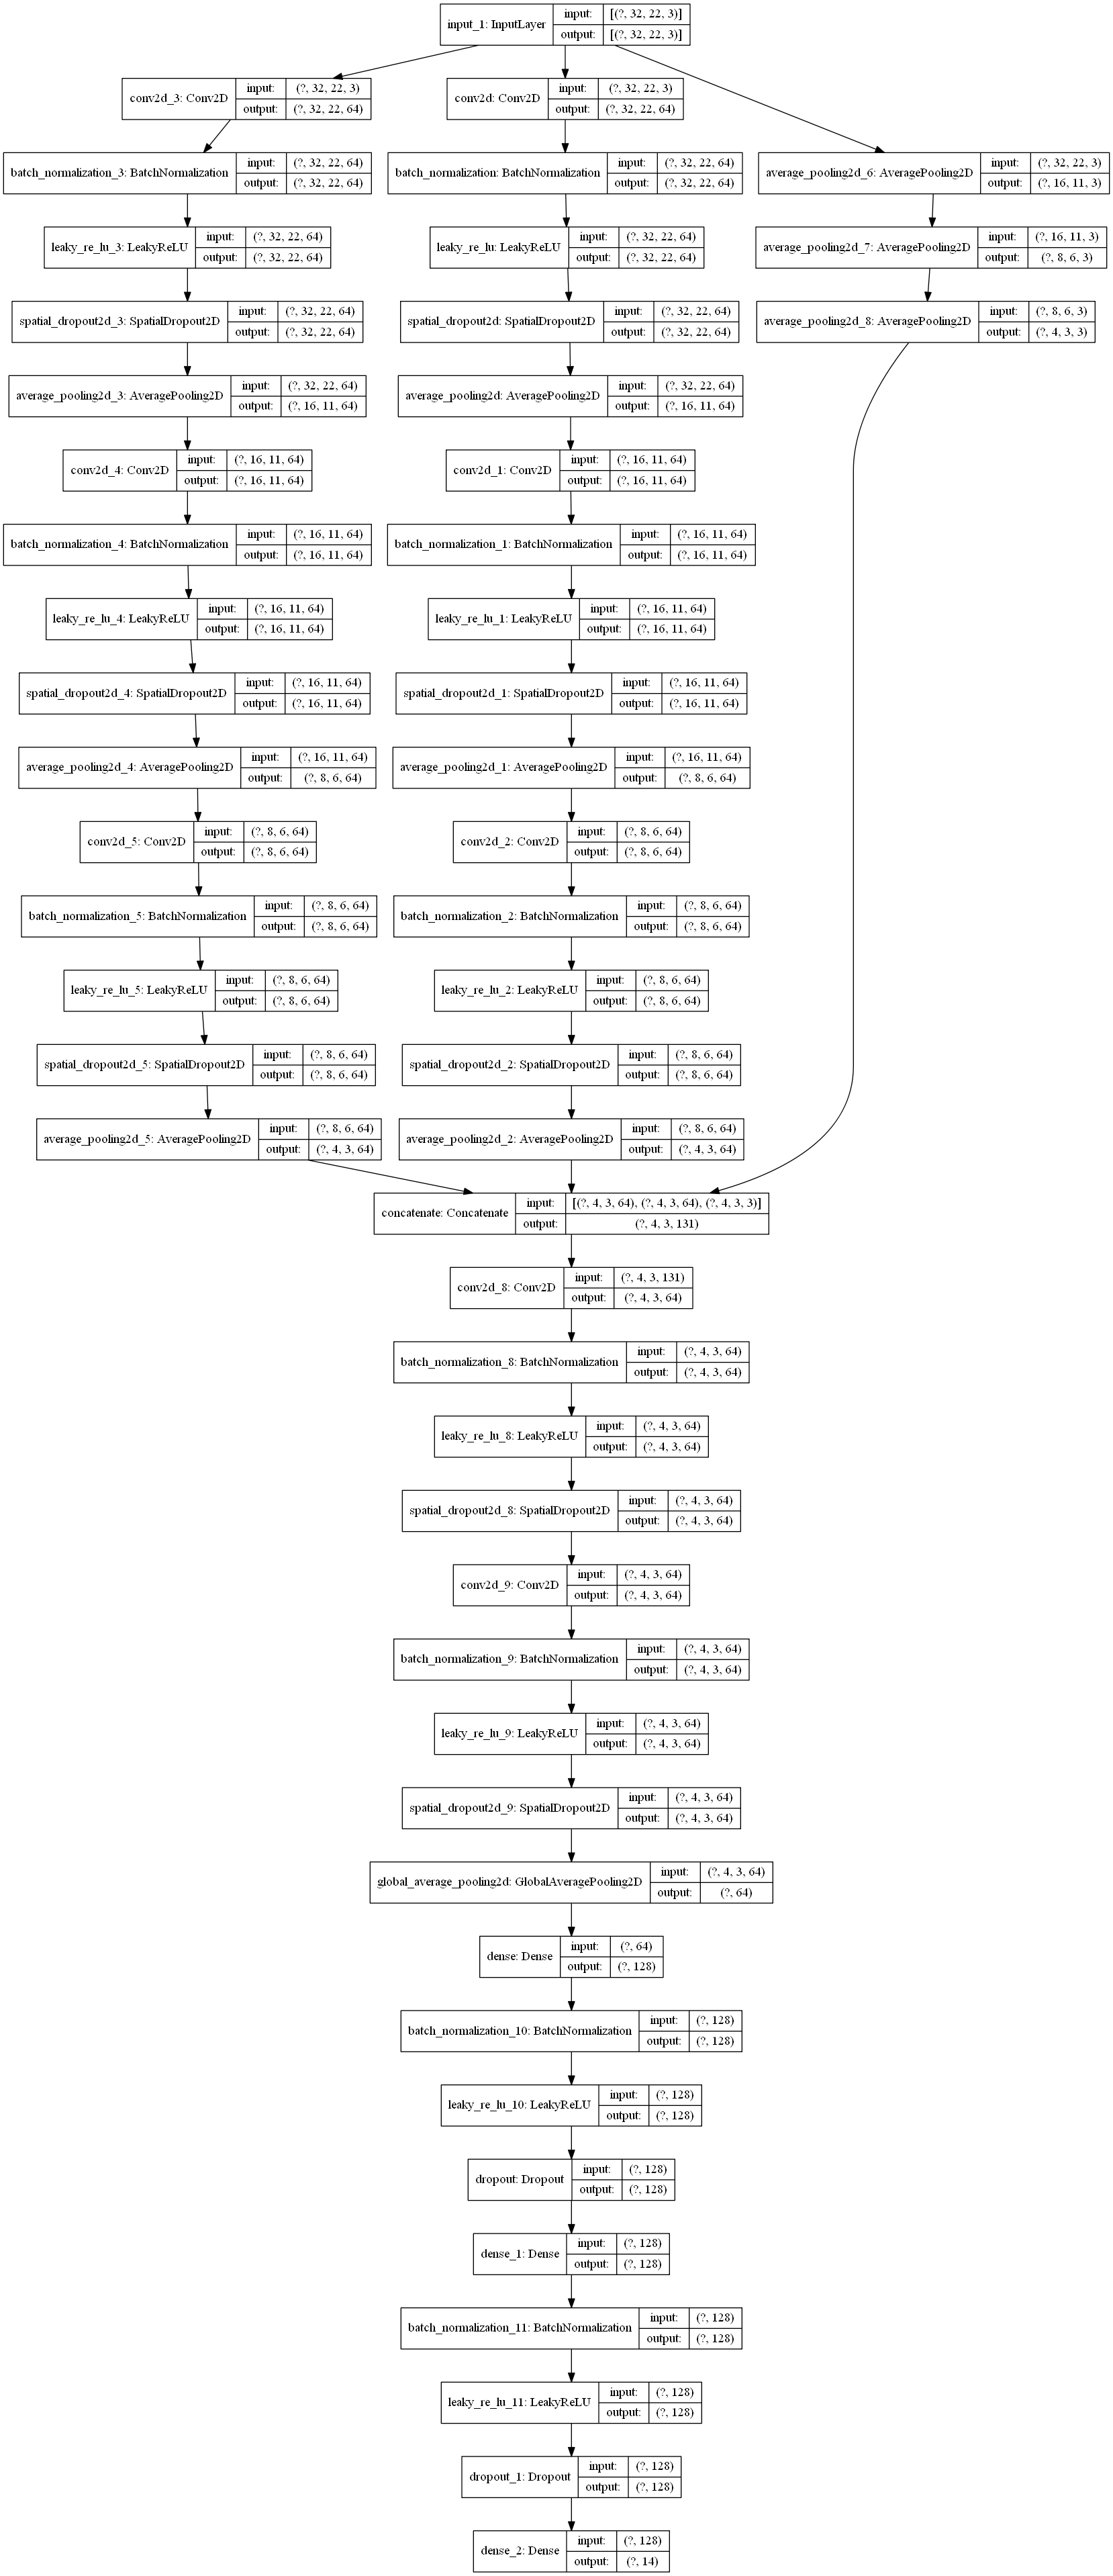

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  2%|█▌                                                                             | 40/1960 [00:00<00:09, 196.58it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 205.74it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 201.30it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=64, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1920/1960 [============================>.] - ETA: 54s - loss: 2.8735 - acc: 0.10 - ETA: 29s - loss: 2.7352 - acc: 0.14 - ETA: 21s - loss: 2.5549 - acc: 0.18 - ETA: 16s - loss: 2.4422 - acc: 0.20 - ETA: 14s - loss: 2.3520 - acc: 0.23 - ETA: 12s - loss: 2.2794 - acc: 0.26 - ETA: 10s - loss: 2.2163 - acc: 0.28 - ETA: 9s - loss: 2.1655 - acc: 0.3027 - ETA: 8s - loss: 2.1111 - acc: 0.316 - ETA: 8s - loss: 2.0482 - acc: 0.335 - ETA: 7s - loss: 2.0010 - acc: 0.362 - ETA: 6s - loss: 1.9684 - acc: 0.371 - ETA: 6s - loss: 1.9358 - acc: 0.379 - ETA: 5s - loss: 1.8991 - acc: 0.395 - ETA: 5s - loss: 1.8559 - acc: 0.408 - ETA: 4s - loss: 1.8207 - acc: 0.420 - ETA: 4s - loss: 1.7968 - acc: 0.427 - ETA: 4s - loss: 1.7764 - acc: 0.436 - ETA: 3s - loss: 1.7372 - acc: 0.451 - ETA: 3s - loss: 1.7102 - acc: 0.461 - ETA: 2s - loss: 1.6879 - acc: 0.465 - ETA: 2s - loss: 1.6582 - acc: 0.479 - ETA: 2s - loss: 1.6314 - acc: 0.488 - ETA: 1s - loss: 1.5

Epoch 00006: val_acc did not improve from 0.57381
1960/1960 [==============================] - 7s 4ms/sample - loss: 0.3613 - acc: 0.8918 - val_loss: 2.6281 - val_acc: 0.2810
Epoch 7/10000
1920/1960 [============================>.] - ETA: 6s - loss: 0.2711 - acc: 0.875 - ETA: 6s - loss: 0.3240 - acc: 0.890 - ETA: 6s - loss: 0.3372 - acc: 0.895 - ETA: 5s - loss: 0.3602 - acc: 0.882 - ETA: 5s - loss: 0.3394 - acc: 0.896 - ETA: 5s - loss: 0.3323 - acc: 0.898 - ETA: 5s - loss: 0.3557 - acc: 0.890 - ETA: 4s - loss: 0.3555 - acc: 0.888 - ETA: 4s - loss: 0.3372 - acc: 0.894 - ETA: 4s - loss: 0.3351 - acc: 0.895 - ETA: 4s - loss: 0.3241 - acc: 0.902 - ETA: 3s - loss: 0.3137 - acc: 0.904 - ETA: 3s - loss: 0.3093 - acc: 0.905 - ETA: 3s - loss: 0.3095 - acc: 0.906 - ETA: 3s - loss: 0.3065 - acc: 0.907 - ETA: 2s - loss: 0.3040 - acc: 0.908 - ETA: 2s - loss: 0.3079 - acc: 0.907 - ETA: 2s - loss: 0.3111 - acc: 0.907 - ETA: 2s - loss: 0.3157 - acc: 0.907 - ETA: 2s - loss: 0.3072 - acc: 0.910 - ETA: 1

1920/1960 [============================>.] - ETA: 5s - loss: 0.3973 - acc: 0.859 - ETA: 5s - loss: 0.3378 - acc: 0.875 - ETA: 5s - loss: 0.2916 - acc: 0.901 - ETA: 5s - loss: 0.2729 - acc: 0.906 - ETA: 5s - loss: 0.2455 - acc: 0.915 - ETA: 5s - loss: 0.2348 - acc: 0.924 - ETA: 5s - loss: 0.2308 - acc: 0.921 - ETA: 4s - loss: 0.2310 - acc: 0.919 - ETA: 4s - loss: 0.2309 - acc: 0.921 - ETA: 4s - loss: 0.2256 - acc: 0.920 - ETA: 4s - loss: 0.2322 - acc: 0.921 - ETA: 3s - loss: 0.2393 - acc: 0.920 - ETA: 3s - loss: 0.2321 - acc: 0.923 - ETA: 3s - loss: 0.2319 - acc: 0.921 - ETA: 3s - loss: 0.2253 - acc: 0.922 - ETA: 3s - loss: 0.2226 - acc: 0.923 - ETA: 2s - loss: 0.2293 - acc: 0.921 - ETA: 2s - loss: 0.2309 - acc: 0.920 - ETA: 2s - loss: 0.2246 - acc: 0.922 - ETA: 2s - loss: 0.2223 - acc: 0.925 - ETA: 2s - loss: 0.2342 - acc: 0.921 - ETA: 1s - loss: 0.2299 - acc: 0.923 - ETA: 1s - loss: 0.2348 - acc: 0.922 - ETA: 1s - loss: 0.2341 - acc: 0.922 - ETA: 1s - loss: 0.2368 - acc: 0.921 - ETA: 

1920/1960 [============================>.] - ETA: 5s - loss: 0.1837 - acc: 0.937 - ETA: 5s - loss: 0.1517 - acc: 0.937 - ETA: 5s - loss: 0.1246 - acc: 0.953 - ETA: 5s - loss: 0.1464 - acc: 0.949 - ETA: 5s - loss: 0.1419 - acc: 0.950 - ETA: 4s - loss: 0.1357 - acc: 0.953 - ETA: 4s - loss: 0.1380 - acc: 0.950 - ETA: 4s - loss: 0.1429 - acc: 0.953 - ETA: 4s - loss: 0.1351 - acc: 0.956 - ETA: 4s - loss: 0.1351 - acc: 0.957 - ETA: 3s - loss: 0.1337 - acc: 0.958 - ETA: 3s - loss: 0.1319 - acc: 0.959 - ETA: 3s - loss: 0.1302 - acc: 0.960 - ETA: 3s - loss: 0.1313 - acc: 0.959 - ETA: 3s - loss: 0.1350 - acc: 0.960 - ETA: 2s - loss: 0.1386 - acc: 0.959 - ETA: 2s - loss: 0.1365 - acc: 0.959 - ETA: 2s - loss: 0.1403 - acc: 0.959 - ETA: 2s - loss: 0.1362 - acc: 0.961 - ETA: 2s - loss: 0.1415 - acc: 0.957 - ETA: 1s - loss: 0.1506 - acc: 0.953 - ETA: 1s - loss: 0.1529 - acc: 0.951 - ETA: 1s - loss: 0.1556 - acc: 0.949 - ETA: 1s - loss: 0.1592 - acc: 0.947 - ETA: 1s - loss: 0.1615 - acc: 0.946 - ETA: 

Epoch 00022: val_acc did not improve from 0.93333
1960/1960 [==============================] - 7s 3ms/sample - loss: 0.1267 - acc: 0.9597 - val_loss: 0.2158 - val_acc: 0.9286
Epoch 23/10000
1920/1960 [============================>.] - ETA: 5s - loss: 0.0489 - acc: 1.000 - ETA: 5s - loss: 0.0456 - acc: 1.000 - ETA: 5s - loss: 0.0700 - acc: 0.989 - ETA: 5s - loss: 0.1216 - acc: 0.984 - ETA: 5s - loss: 0.1268 - acc: 0.975 - ETA: 4s - loss: 0.1431 - acc: 0.963 - ETA: 4s - loss: 0.1387 - acc: 0.962 - ETA: 4s - loss: 0.1284 - acc: 0.964 - ETA: 4s - loss: 0.1281 - acc: 0.965 - ETA: 4s - loss: 0.1267 - acc: 0.967 - ETA: 3s - loss: 0.1269 - acc: 0.967 - ETA: 3s - loss: 0.1277 - acc: 0.967 - ETA: 3s - loss: 0.1291 - acc: 0.966 - ETA: 3s - loss: 0.1303 - acc: 0.965 - ETA: 3s - loss: 0.1324 - acc: 0.965 - ETA: 2s - loss: 0.1317 - acc: 0.966 - ETA: 2s - loss: 0.1295 - acc: 0.966 - ETA: 2s - loss: 0.1261 - acc: 0.967 - ETA: 2s - loss: 0.1282 - acc: 0.967 - ETA: 2s - loss: 0.1268 - acc: 0.966 - ETA: 

1920/1960 [============================>.] - ETA: 6s - loss: 0.1037 - acc: 0.968 - ETA: 5s - loss: 0.1062 - acc: 0.976 - ETA: 5s - loss: 0.0945 - acc: 0.974 - ETA: 5s - loss: 0.1150 - acc: 0.964 - ETA: 5s - loss: 0.1060 - acc: 0.968 - ETA: 5s - loss: 0.1296 - acc: 0.960 - ETA: 5s - loss: 0.1211 - acc: 0.964 - ETA: 4s - loss: 0.1128 - acc: 0.966 - ETA: 4s - loss: 0.1100 - acc: 0.965 - ETA: 4s - loss: 0.1131 - acc: 0.962 - ETA: 4s - loss: 0.1125 - acc: 0.963 - ETA: 3s - loss: 0.1140 - acc: 0.962 - ETA: 3s - loss: 0.1116 - acc: 0.963 - ETA: 3s - loss: 0.1071 - acc: 0.965 - ETA: 3s - loss: 0.1051 - acc: 0.965 - ETA: 3s - loss: 0.1122 - acc: 0.962 - ETA: 2s - loss: 0.1146 - acc: 0.962 - ETA: 2s - loss: 0.1149 - acc: 0.960 - ETA: 2s - loss: 0.1142 - acc: 0.961 - ETA: 2s - loss: 0.1165 - acc: 0.960 - ETA: 2s - loss: 0.1182 - acc: 0.961 - ETA: 1s - loss: 0.1183 - acc: 0.961 - ETA: 1s - loss: 0.1214 - acc: 0.959 - ETA: 1s - loss: 0.1178 - acc: 0.961 - ETA: 1s - loss: 0.1164 - acc: 0.962 - ETA: 

1960/1960 [==============================] - 7s 4ms/sample - loss: 0.0738 - acc: 0.9760 - val_loss: 0.1916 - val_acc: 0.9488
Epoch 34/10000
1920/1960 [============================>.] - ETA: 5s - loss: 0.0285 - acc: 1.000 - ETA: 5s - loss: 0.0587 - acc: 0.992 - ETA: 5s - loss: 0.0453 - acc: 0.994 - ETA: 5s - loss: 0.0383 - acc: 0.996 - ETA: 5s - loss: 0.0341 - acc: 0.996 - ETA: 4s - loss: 0.0328 - acc: 0.997 - ETA: 4s - loss: 0.0358 - acc: 0.995 - ETA: 4s - loss: 0.0414 - acc: 0.994 - ETA: 4s - loss: 0.0417 - acc: 0.993 - ETA: 4s - loss: 0.0438 - acc: 0.990 - ETA: 3s - loss: 0.0450 - acc: 0.990 - ETA: 3s - loss: 0.0501 - acc: 0.988 - ETA: 3s - loss: 0.0486 - acc: 0.989 - ETA: 3s - loss: 0.0528 - acc: 0.987 - ETA: 3s - loss: 0.0513 - acc: 0.988 - ETA: 2s - loss: 0.0589 - acc: 0.986 - ETA: 2s - loss: 0.0575 - acc: 0.986 - ETA: 2s - loss: 0.0562 - acc: 0.987 - ETA: 2s - loss: 0.0551 - acc: 0.986 - ETA: 2s - loss: 0.0556 - acc: 0.985 - ETA: 1s - loss: 0.0547 - acc: 0.985 - ETA: 1s - loss: 0

1920/1960 [============================>.] - ETA: 6s - loss: 0.0578 - acc: 0.953 - ETA: 5s - loss: 0.0741 - acc: 0.968 - ETA: 5s - loss: 0.0742 - acc: 0.963 - ETA: 5s - loss: 0.0628 - acc: 0.972 - ETA: 5s - loss: 0.0545 - acc: 0.978 - ETA: 5s - loss: 0.0512 - acc: 0.979 - ETA: 4s - loss: 0.0517 - acc: 0.979 - ETA: 4s - loss: 0.0543 - acc: 0.976 - ETA: 4s - loss: 0.0527 - acc: 0.979 - ETA: 4s - loss: 0.0544 - acc: 0.979 - ETA: 3s - loss: 0.0562 - acc: 0.977 - ETA: 3s - loss: 0.0529 - acc: 0.979 - ETA: 3s - loss: 0.0537 - acc: 0.978 - ETA: 3s - loss: 0.0522 - acc: 0.977 - ETA: 3s - loss: 0.0499 - acc: 0.979 - ETA: 2s - loss: 0.0482 - acc: 0.980 - ETA: 2s - loss: 0.0471 - acc: 0.981 - ETA: 2s - loss: 0.0468 - acc: 0.982 - ETA: 2s - loss: 0.0474 - acc: 0.982 - ETA: 2s - loss: 0.0471 - acc: 0.983 - ETA: 1s - loss: 0.0459 - acc: 0.984 - ETA: 1s - loss: 0.0452 - acc: 0.984 - ETA: 1s - loss: 0.0465 - acc: 0.984 - ETA: 1s - loss: 0.0473 - acc: 0.984 - ETA: 1s - loss: 0.0465 - acc: 0.985 - ETA: 

1960/1960 [==============================] - 6s 3ms/sample - loss: 0.0561 - acc: 0.9816 - val_loss: 0.1905 - val_acc: 0.9452
Epoch 45/10000
1920/1960 [============================>.] - ETA: 5s - loss: 0.0411 - acc: 0.984 - ETA: 5s - loss: 0.0662 - acc: 0.984 - ETA: 5s - loss: 0.0593 - acc: 0.984 - ETA: 5s - loss: 0.0474 - acc: 0.988 - ETA: 5s - loss: 0.0634 - acc: 0.981 - ETA: 5s - loss: 0.0557 - acc: 0.984 - ETA: 4s - loss: 0.0617 - acc: 0.982 - ETA: 4s - loss: 0.0673 - acc: 0.980 - ETA: 4s - loss: 0.0648 - acc: 0.980 - ETA: 4s - loss: 0.0648 - acc: 0.981 - ETA: 4s - loss: 0.0620 - acc: 0.983 - ETA: 3s - loss: 0.0591 - acc: 0.984 - ETA: 3s - loss: 0.0583 - acc: 0.985 - ETA: 3s - loss: 0.0553 - acc: 0.986 - ETA: 3s - loss: 0.0543 - acc: 0.986 - ETA: 3s - loss: 0.0524 - acc: 0.987 - ETA: 2s - loss: 0.0527 - acc: 0.987 - ETA: 2s - loss: 0.0545 - acc: 0.986 - ETA: 2s - loss: 0.0522 - acc: 0.986 - ETA: 2s - loss: 0.0515 - acc: 0.986 - ETA: 1s - loss: 0.0523 - acc: 0.985 - ETA: 1s - loss: 0

1920/1960 [============================>.] - ETA: 5s - loss: 0.0106 - acc: 1.000 - ETA: 5s - loss: 0.0266 - acc: 1.000 - ETA: 5s - loss: 0.0243 - acc: 1.000 - ETA: 5s - loss: 0.0371 - acc: 0.996 - ETA: 5s - loss: 0.0318 - acc: 0.996 - ETA: 4s - loss: 0.0404 - acc: 0.989 - ETA: 4s - loss: 0.0370 - acc: 0.991 - ETA: 4s - loss: 0.0385 - acc: 0.992 - ETA: 4s - loss: 0.0364 - acc: 0.993 - ETA: 4s - loss: 0.0361 - acc: 0.993 - ETA: 3s - loss: 0.0358 - acc: 0.994 - ETA: 3s - loss: 0.0363 - acc: 0.993 - ETA: 3s - loss: 0.0353 - acc: 0.992 - ETA: 3s - loss: 0.0364 - acc: 0.992 - ETA: 3s - loss: 0.0349 - acc: 0.992 - ETA: 2s - loss: 0.0367 - acc: 0.990 - ETA: 2s - loss: 0.0403 - acc: 0.989 - ETA: 2s - loss: 0.0410 - acc: 0.988 - ETA: 2s - loss: 0.0396 - acc: 0.989 - ETA: 2s - loss: 0.0397 - acc: 0.989 - ETA: 1s - loss: 0.0407 - acc: 0.988 - ETA: 1s - loss: 0.0412 - acc: 0.988 - ETA: 1s - loss: 0.0403 - acc: 0.989 - ETA: 1s - loss: 0.0396 - acc: 0.989 - ETA: 1s - loss: 0.0402 - acc: 0.989 - ETA: 

Epoch 56/10000
1920/1960 [============================>.] - ETA: 5s - loss: 0.0884 - acc: 0.984 - ETA: 5s - loss: 0.0579 - acc: 0.984 - ETA: 5s - loss: 0.0654 - acc: 0.984 - ETA: 5s - loss: 0.0523 - acc: 0.988 - ETA: 5s - loss: 0.0484 - acc: 0.990 - ETA: 4s - loss: 0.0425 - acc: 0.992 - ETA: 4s - loss: 0.0372 - acc: 0.993 - ETA: 4s - loss: 0.0342 - acc: 0.994 - ETA: 4s - loss: 0.0330 - acc: 0.994 - ETA: 4s - loss: 0.0316 - acc: 0.995 - ETA: 4s - loss: 0.0308 - acc: 0.995 - ETA: 3s - loss: 0.0319 - acc: 0.994 - ETA: 3s - loss: 0.0313 - acc: 0.995 - ETA: 3s - loss: 0.0340 - acc: 0.992 - ETA: 3s - loss: 0.0334 - acc: 0.992 - ETA: 3s - loss: 0.0325 - acc: 0.993 - ETA: 2s - loss: 0.0346 - acc: 0.991 - ETA: 2s - loss: 0.0368 - acc: 0.990 - ETA: 2s - loss: 0.0353 - acc: 0.991 - ETA: 2s - loss: 0.0345 - acc: 0.991 - ETA: 1s - loss: 0.0335 - acc: 0.991 - ETA: 1s - loss: 0.0330 - acc: 0.991 - ETA: 1s - loss: 0.0324 - acc: 0.991 - ETA: 1s - loss: 0.0317 - acc: 0.991 - ETA: 1s - loss: 0.0324 - acc

Epoch 62/10000
1920/1960 [============================>.] - ETA: 5s - loss: 0.1040 - acc: 0.984 - ETA: 5s - loss: 0.0643 - acc: 0.992 - ETA: 5s - loss: 0.0509 - acc: 0.994 - ETA: 5s - loss: 0.0484 - acc: 0.992 - ETA: 5s - loss: 0.0407 - acc: 0.993 - ETA: 4s - loss: 0.0370 - acc: 0.994 - ETA: 4s - loss: 0.0335 - acc: 0.995 - ETA: 4s - loss: 0.0306 - acc: 0.996 - ETA: 4s - loss: 0.0327 - acc: 0.994 - ETA: 4s - loss: 0.0313 - acc: 0.995 - ETA: 4s - loss: 0.0296 - acc: 0.995 - ETA: 3s - loss: 0.0281 - acc: 0.996 - ETA: 3s - loss: 0.0289 - acc: 0.995 - ETA: 3s - loss: 0.0290 - acc: 0.995 - ETA: 3s - loss: 0.0313 - acc: 0.994 - ETA: 2s - loss: 0.0299 - acc: 0.995 - ETA: 2s - loss: 0.0304 - acc: 0.994 - ETA: 2s - loss: 0.0315 - acc: 0.993 - ETA: 2s - loss: 0.0313 - acc: 0.993 - ETA: 2s - loss: 0.0362 - acc: 0.992 - ETA: 1s - loss: 0.0348 - acc: 0.992 - ETA: 1s - loss: 0.0340 - acc: 0.992 - ETA: 1s - loss: 0.0338 - acc: 0.993 - ETA: 1s - loss: 0.0335 - acc: 0.993 - ETA: 1s - loss: 0.0339 - acc

Epoch 68/10000
1920/1960 [============================>.] - ETA: 5s - loss: 0.0448 - acc: 0.984 - ETA: 5s - loss: 0.0316 - acc: 0.992 - ETA: 5s - loss: 0.0350 - acc: 0.989 - ETA: 5s - loss: 0.0312 - acc: 0.992 - ETA: 5s - loss: 0.0355 - acc: 0.990 - ETA: 4s - loss: 0.0344 - acc: 0.992 - ETA: 4s - loss: 0.0370 - acc: 0.991 - ETA: 4s - loss: 0.0406 - acc: 0.990 - ETA: 4s - loss: 0.0403 - acc: 0.989 - ETA: 4s - loss: 0.0398 - acc: 0.990 - ETA: 3s - loss: 0.0420 - acc: 0.988 - ETA: 3s - loss: 0.0423 - acc: 0.987 - ETA: 3s - loss: 0.0407 - acc: 0.986 - ETA: 3s - loss: 0.0397 - acc: 0.987 - ETA: 3s - loss: 0.0389 - acc: 0.987 - ETA: 2s - loss: 0.0379 - acc: 0.988 - ETA: 2s - loss: 0.0374 - acc: 0.988 - ETA: 2s - loss: 0.0377 - acc: 0.987 - ETA: 2s - loss: 0.0386 - acc: 0.987 - ETA: 2s - loss: 0.0395 - acc: 0.987 - ETA: 1s - loss: 0.0387 - acc: 0.988 - ETA: 1s - loss: 0.0398 - acc: 0.987 - ETA: 1s - loss: 0.0383 - acc: 0.988 - ETA: 1s - loss: 0.0391 - acc: 0.988 - ETA: 1s - loss: 0.0384 - acc

Epoch 74/10000
1920/1960 [============================>.] - ETA: 6s - loss: 0.0901 - acc: 0.968 - ETA: 6s - loss: 0.0546 - acc: 0.984 - ETA: 6s - loss: 0.0385 - acc: 0.989 - ETA: 6s - loss: 0.0329 - acc: 0.992 - ETA: 5s - loss: 0.0488 - acc: 0.984 - ETA: 5s - loss: 0.0444 - acc: 0.987 - ETA: 5s - loss: 0.0464 - acc: 0.986 - ETA: 5s - loss: 0.0474 - acc: 0.982 - ETA: 4s - loss: 0.0436 - acc: 0.984 - ETA: 4s - loss: 0.0416 - acc: 0.985 - ETA: 4s - loss: 0.0402 - acc: 0.987 - ETA: 4s - loss: 0.0448 - acc: 0.985 - ETA: 4s - loss: 0.0438 - acc: 0.985 - ETA: 3s - loss: 0.0446 - acc: 0.985 - ETA: 3s - loss: 0.0444 - acc: 0.985 - ETA: 3s - loss: 0.0453 - acc: 0.985 - ETA: 3s - loss: 0.0437 - acc: 0.986 - ETA: 2s - loss: 0.0437 - acc: 0.986 - ETA: 2s - loss: 0.0437 - acc: 0.986 - ETA: 2s - loss: 0.0425 - acc: 0.986 - ETA: 2s - loss: 0.0409 - acc: 0.987 - ETA: 1s - loss: 0.0402 - acc: 0.987 - ETA: 1s - loss: 0.0427 - acc: 0.987 - ETA: 1s - loss: 0.0413 - acc: 0.987 - ETA: 1s - loss: 0.0410 - acc

Epoch 80/10000
1920/1960 [============================>.] - ETA: 5s - loss: 0.0246 - acc: 1.000 - ETA: 5s - loss: 0.0383 - acc: 0.984 - ETA: 5s - loss: 0.0278 - acc: 0.989 - ETA: 5s - loss: 0.0248 - acc: 0.992 - ETA: 5s - loss: 0.0281 - acc: 0.987 - ETA: 5s - loss: 0.0246 - acc: 0.989 - ETA: 4s - loss: 0.0225 - acc: 0.991 - ETA: 4s - loss: 0.0211 - acc: 0.992 - ETA: 4s - loss: 0.0260 - acc: 0.991 - ETA: 4s - loss: 0.0272 - acc: 0.990 - ETA: 4s - loss: 0.0329 - acc: 0.988 - ETA: 3s - loss: 0.0318 - acc: 0.989 - ETA: 3s - loss: 0.0305 - acc: 0.990 - ETA: 3s - loss: 0.0301 - acc: 0.991 - ETA: 3s - loss: 0.0286 - acc: 0.991 - ETA: 3s - loss: 0.0288 - acc: 0.991 - ETA: 2s - loss: 0.0280 - acc: 0.991 - ETA: 2s - loss: 0.0279 - acc: 0.992 - ETA: 2s - loss: 0.0306 - acc: 0.991 - ETA: 2s - loss: 0.0331 - acc: 0.989 - ETA: 2s - loss: 0.0321 - acc: 0.989 - ETA: 1s - loss: 0.0319 - acc: 0.989 - ETA: 1s - loss: 0.0322 - acc: 0.989 - ETA: 1s - loss: 0.0321 - acc: 0.988 - ETA: 1s - loss: 0.0314 - acc

Epoch 86/10000
1920/1960 [============================>.] - ETA: 5s - loss: 0.0136 - acc: 1.000 - ETA: 5s - loss: 0.0217 - acc: 0.992 - ETA: 5s - loss: 0.0310 - acc: 0.984 - ETA: 5s - loss: 0.0280 - acc: 0.988 - ETA: 5s - loss: 0.0237 - acc: 0.990 - ETA: 4s - loss: 0.0273 - acc: 0.987 - ETA: 4s - loss: 0.0286 - acc: 0.986 - ETA: 4s - loss: 0.0279 - acc: 0.988 - ETA: 4s - loss: 0.0268 - acc: 0.989 - ETA: 4s - loss: 0.0253 - acc: 0.990 - ETA: 3s - loss: 0.0281 - acc: 0.990 - ETA: 3s - loss: 0.0275 - acc: 0.990 - ETA: 3s - loss: 0.0262 - acc: 0.991 - ETA: 3s - loss: 0.0275 - acc: 0.991 - ETA: 3s - loss: 0.0276 - acc: 0.990 - ETA: 2s - loss: 0.0288 - acc: 0.990 - ETA: 2s - loss: 0.0285 - acc: 0.990 - ETA: 2s - loss: 0.0319 - acc: 0.989 - ETA: 2s - loss: 0.0336 - acc: 0.989 - ETA: 2s - loss: 0.0329 - acc: 0.989 - ETA: 1s - loss: 0.0343 - acc: 0.989 - ETA: 1s - loss: 0.0352 - acc: 0.989 - ETA: 1s - loss: 0.0348 - acc: 0.989 - ETA: 1s - loss: 0.0340 - acc: 0.990 - ETA: 1s - loss: 0.0339 - acc

In [16]:
print(max(history.history['val_acc']))

0.9595238


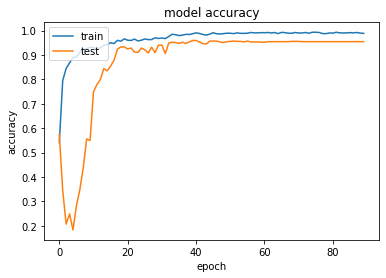

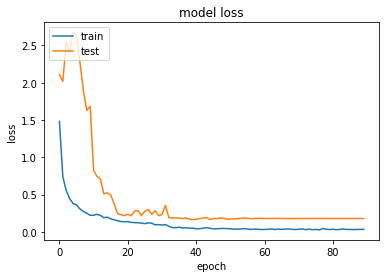

In [17]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

1960/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 1s 599us/sample - loss: 0.0072 - acc: 0.9974


840/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 99.74%
Accuracy on test set: 95.95%


In [20]:
Y_pred = model.predict(X_test_1)
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

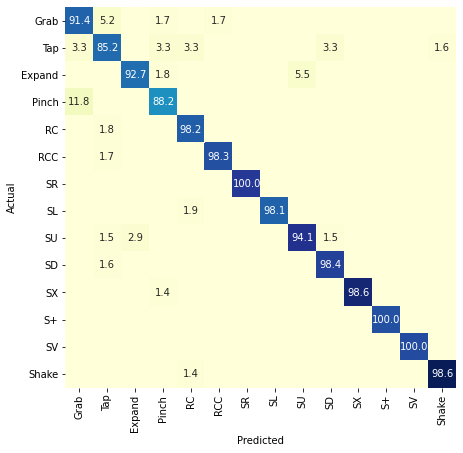

In [21]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

In [22]:
Y_pred = model.predict(X_test_1)
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

E:\Skelnet2D\SHREC\utils.py:83: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


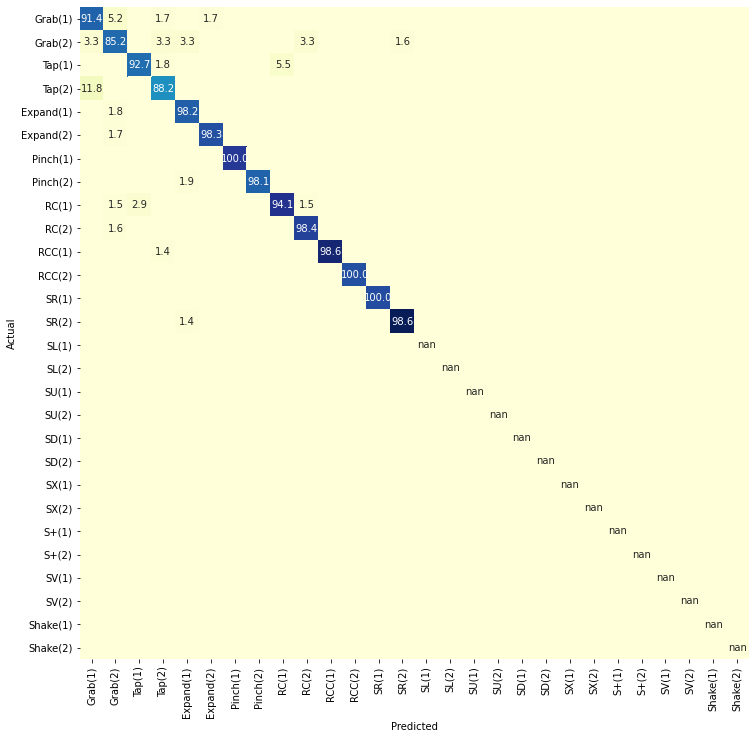

In [23]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_28.png', labels, ymap=None, figsize=(12,12))